In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({"text.usetex": True,"text.latex.preamble": r"\usepackage{bm}"})
%matplotlib inline

from multiprocessing import Pool, shared_memory
from functools import partial
import tqdm


from lens_map import *
import gaussian_source as src
import random_deflection


arcmin = np.pi/(180*60.)
arcsec = np.pi/(180*60.*60.)
microarcsec = 1e-6*arcsec

In [2]:

# Parameters that determine the lens equation near the caustic - see Schneider, Ehlers and Falco Ch. 6
phi_11, phi_22 = 0.8, 0.0 # This makes the caustic a horizontal line in the source plane

# These are chosen such that the caustic is well approximated by a parabola, i.e. so that we can compare with analytics
phi_111, phi_112, phi_122, phi_222 = 0.06/5., 0.05/5., 0.03/5., 0.05/5.

# This parameter controls the magnification
g = 2 / (phi_11 ** 2 * phi_222)

caustic_params = {'phi_11':phi_11, 'phi_22':phi_22, 'phi_111':phi_111, 'phi_112':phi_112, 'phi_122':phi_122, 'phi_222':phi_222}



# Size and discretization of the lens and source planes
num_pixel_lns, num_pixel_src = 2001, 2001 # Number of pixels in both planes
half_size_lns, half_size_src = 4.0, 0.1 # Half size of the lens and source planes
pixel_size_lns, pixel_size_src = 2.0 * half_size_lns / (num_pixel_lns - 1), 2.0 * half_size_src / (num_pixel_src - 1) # horizontal and vertical physical pixel size

# Random noise - make sure parameters supplied to power spectrum are in radians
deflection_params = {'pixel_size_in_rad':pixel_size_lns*microarcsec, 'num_pixel':num_pixel_lns, 'area_in_rad_sq': (2.*half_size_lns*microarcsec)**2} 
#Parameters needed for power spectrum here
ps_params = {'M':2e-6, 'c': 1200, 'DL': 1.35, 'DS':1.79, 'DLS':0.95, 'dm_mass_fraction':1}
deflection_params['ps_params'] = ps_params
# the output is in rad, so convert it to microarcsec
caustic_params['random_deflection'] = random_deflection.generate_random_field(deflection_params)/microarcsec


# indices for the lens plane pixels.
# Note: arrays are indexed as by [j1,j2], so j2 (j1) indexes horizontal (vertical) directions
j1, j2 = np.mgrid[0:num_pixel_lns, 0:num_pixel_lns] 

# this maps pixels indices to physical coord as [0,0] -> (-L,L), [0,N-1]-> (L,L) etc
x1, x2 = pixel_to_pos(j2, -half_size_lns, pixel_size_lns), pixel_to_pos(j1,half_size_lns, -pixel_size_lns)

y1, y2 = lens_mapping(x1, x2, caustic_params)

# Convert deflected coordinates to source plane pixels
i1, i2 = pos_to_pixel(y2, half_size_src, -pixel_size_src), pos_to_pixel(y1, -half_size_src, pixel_size_src)

Text(0, 0.5, '$x_2$ [$\\mu$as]')

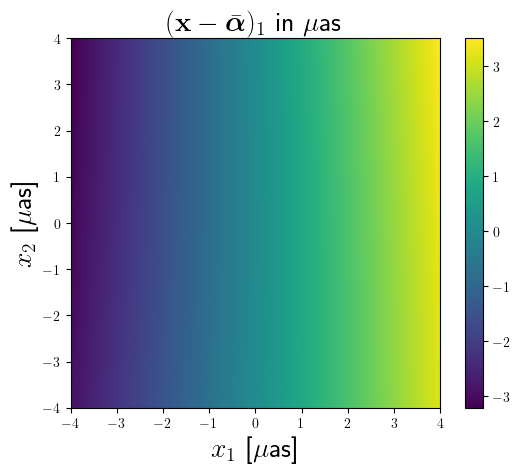

In [3]:

y1_plot = plt.imshow(y1,extent=(-half_size_lns,half_size_lns,-half_size_lns,half_size_lns))
plt.colorbar(y1_plot)
plt.title(r'$(\mathbf{x} - \bar{\bm{\alpha}})_1$ in $\mu$as',fontsize=20)
plt.xlim([-half_size_lns,half_size_lns])
plt.ylim([-half_size_lns,half_size_lns])
plt.xlabel(r'$x_1$ [$\mu$as]',fontsize=20)
plt.ylabel(r'$x_2$ [$\mu$as]',fontsize=20)

In [4]:
jac = lens_mapping_jacobian(x1,x2,caustic_params)
print(jac.shape)
print(jac[0,0,:,:])

(2001, 2001, 2, 2)
[[ 0.792 -0.016]
 [-0.016  0.016]]


/tmp/ipykernel_43453/3353252241.py:2: RuntimeWarning: divide by zero encountered in divide
  jac_plt = plt.imshow(1/np.abs(jac_det),vmin=1,vmax=500,extent=(-half_size_lns,half_size_lns,-half_size_lns,half_size_lns))


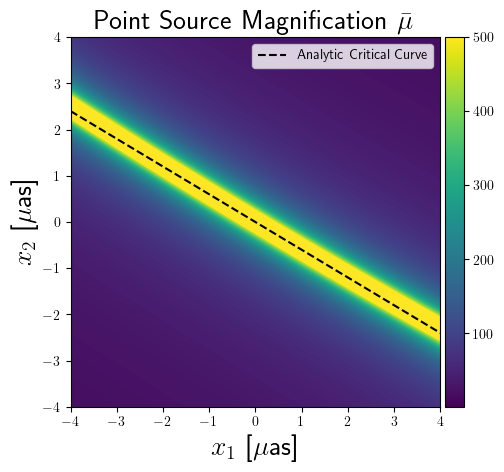

In [5]:

jac_det = np.linalg.det(jac)
jac_plt = plt.imshow(1/np.abs(jac_det),vmin=1,vmax=500,extent=(-half_size_lns,half_size_lns,-half_size_lns,half_size_lns))
plt.plot(x1[0], - phi_122 * x1[0] / phi_222,c='k',ls='--',label='Analytic Critical Curve')
plt.title(r"Point Source Magnification $\bar\mu$",fontsize=20)

plt.xlabel(r'$x_1$ [$\mu$as]',fontsize=20)
plt.ylabel(r'$x_2$ [$\mu$as]',fontsize=20)
plt.legend()
p = plt.gca()
divider1 = make_axes_locatable(p)
cax = divider1.append_axes("right", size="5%", pad=0.05)
plt.gca().figure.colorbar(jac_plt, cax=cax)




In [6]:
delta_alpha, delta_alpha_jac =random_deflection.generate_random_field(deflection_params, compute_jacobian=True)
delta_alpha /= microarcsec


Text(0, 0.5, '$x_2$ [$\\mu$as]')

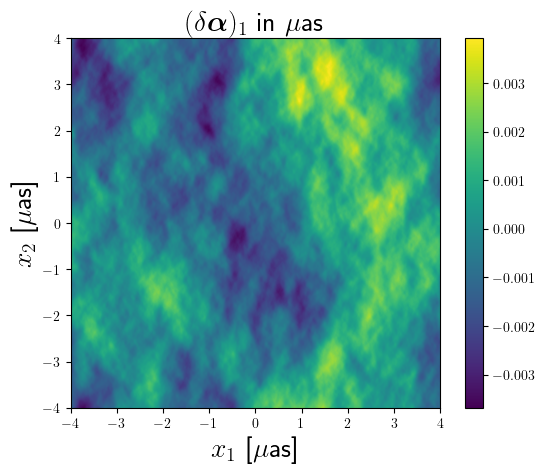

In [7]:

y1_plot = plt.imshow(delta_alpha[0],extent=(-half_size_lns,half_size_lns,-half_size_lns,half_size_lns))
plt.colorbar(y1_plot)
plt.title(r'$(\delta\bm{\alpha})_1$ in $\mu$as',fontsize=20)
plt.xlim([-half_size_lns,half_size_lns])
plt.ylim([-half_size_lns,half_size_lns])
plt.xlabel(r'$x_1$ [$\mu$as]',fontsize=20)
plt.ylabel(r'$x_2$ [$\mu$as]',fontsize=20)

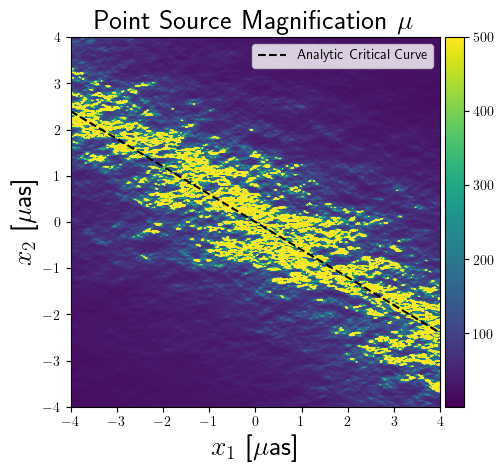

In [8]:
jac_det = np.linalg.det(jac+delta_alpha_jac)
jac_plt = plt.imshow(1/np.abs(jac_det),vmin=1,vmax=500,extent=(-half_size_lns,half_size_lns,-half_size_lns,half_size_lns))
plt.plot(x1[0], - phi_122 * x1[0] / phi_222,c='k',ls='--',label='Analytic Critical Curve')
plt.title(r"Point Source Magnification $\mu$",fontsize=20)

plt.xlabel(r'$x_1$ [$\mu$as]',fontsize=20)
plt.ylabel(r'$x_2$ [$\mu$as]',fontsize=20)
plt.legend()
p = plt.gca()
divider1 = make_axes_locatable(p)
cax = divider1.append_axes("right", size="5%", pad=0.05)
plt.gca().figure.colorbar(jac_plt, cax=cax)